<a href="https://colab.research.google.com/github/MaryamNikpasand/Grading/blob/main/Disc/GradingDisc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
!pip install -q -U keras-tuner
import keras_tuner as kt
import matplotlib.pyplot as plt
import random
import pandas as pd
!pip install xlrd

from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
from scipy import ndimage
from tensorflow.keras import regularizers
from tensorflow.keras import initializers


# data

In [ ]:
def read_files(filepath):
  """Read and load volume"""
  # Read file
  scan=plt.imread(filepath)
  # plt.imshow(scan, cmap = plt.cm.gray)
  # plt.show()
  # Get raw data
  return scan

def normalize(volume):
  """normalize the volume
     Normalize with mean and std of each image
  """
  Mean=np.mean(volume)
  Std=np.std(volume)
  volume=(volume-Mean)/Std
  volume=volume.astype("float32")
  return volume

def resize_volume(img):
  """Resize across z-axis"""
  # Set the desired depth
  desired_width = 64
  desired_height = 64
  # Get current depth
  current_width = img.shape[0]
  current_height = img.shape[-1]
  # Compute depth factor
  width = current_width / desired_width
  height = current_height / desired_height
  width_factor = 1 / width
  height_factor = 1 / height
  # Resize across z-axis
  img = ndimage.zoom(img, (width_factor, height_factor), order=1)
  # resize_and_rescale = tf.keras.Sequential([
  #   layers.experimental.preprocessing.Resizing(desired_width, desired_height, desired_depth)])
  # img = resize_and_rescale(tf.expand_dims(img, axis=-1))
  return img

def process_scan(path):
  """Read and resize volume"""
  # Read scan
  volume=read_files(path)
  # Normalize
  volume=normalize(volume)
  volume=resize_volume(volume)
  volume=tf.expand_dims(volume,axis=-1) #  Adding an extra dimension to the images to have them in (x,x,1) format 
  return volume

In [ ]:
"""
Read images path and save them in Disc_path dictionary.
shuffle the paths.
read the images and process them
"""

# Folder "Disc" consist of MRI scans having Disc images,
Disc_paths = dict()
filepath_Disc='/content/drive/MyDrive/PhD/Barocas/grading/LumbarDiscJointScoring_Main/ImageSelection/Discs/Ladd'
for x in os.listdir(filepath_Disc):
    for y in os.listdir(os.path.join(filepath_Disc,x)):
        if x not in Disc_paths:
            Disc_paths[x] = [os.path.join(filepath_Disc, x, y)]
        else:
            Disc_paths[x].append(os.path.join(filepath_Disc, x, y))

print("Disc['grade1']:: " + str(len(Disc_paths['grade1'])))
print("Disc['grade2']:: " + str(len(Disc_paths['grade2'])))
print("Disc['grade3']:: " + str(len(Disc_paths['grade3'])))
print("Disc['grade4']:: " + str(len(Disc_paths['grade4'])))
print("Disc['grade5']:: " + str(len(Disc_paths['grade5'])))

random.shuffle(Disc_paths['grade1'])
random.shuffle(Disc_paths['grade2'])
random.shuffle(Disc_paths['grade3'])
random.shuffle(Disc_paths['grade4'])
random.shuffle(Disc_paths['grade5'])

# Read and process the scans.
Disc_grade1 = np.array([process_scan(path) for path in Disc_paths['grade1']])
Disc_grade2 = np.array([process_scan(path) for path in Disc_paths['grade2']])
Disc_grade3 = np.array([process_scan(path) for path in Disc_paths['grade3']])
Disc_grade4 = np.array([process_scan(path) for path in Disc_paths['grade4']])
Disc_grade5 = np.array([process_scan(path) for path in Disc_paths['grade5']])



Disc['grade1']:: 55
Disc['grade2']:: 615
Disc['grade3']:: 1002
Disc['grade4']:: 876
Disc['grade5']:: 85


In [ ]:
"""
Save the processed images as np array.
Save th Disc_path in a text file (Disc_paths_file.txt)
"""

directory = "3D_CTscan" # Save the entire model as a SavedModel.
# parent_dir = os.getcwd() # Parent Directory path
parent_dir = '/content/drive/MyDrive/PhD/Barocas/grading/MyModels/DiscGrade'
path = os.path.join(parent_dir, directory) # Path
os.makedirs(path,exist_ok=True) # Create the directory

np.save(os.path.join(path,'Disc_grade1.npy'), Disc_grade1)
np.save(os.path.join(path,'Disc_grade2.npy'), Disc_grade2)
np.save(os.path.join(path,'Disc_grade3.npy'), Disc_grade3)
np.save(os.path.join(path,'Disc_grade4.npy'), Disc_grade4)
np.save(os.path.join(path,'Disc_grade5.npy'), Disc_grade5)


textfile = open(os.path.join(path, "Disc_paths_file.txt"), "w")
for element in Disc_paths:
    # print(key, '->', a_dict[key])
    textfile.write(element + ":\n")
    for value in Disc_paths[element]:
      textfile.write(value + "\n")
textfile.close()

NameError: ignored

In [ ]:
"""
Load the saved processed imagaes so that it is faster to generate data
"""
directory = "3D_CTscan" # Save the entire model as a SavedModel.
parent_dir = '/content/drive/MyDrive/PhD/Barocas/grading/MyModels/DiscGrade'
path = os.path.join(parent_dir, directory) # Path

lines = []
line_number = []
Disc_paths = dict()
with open(os.path.join(path, "Disc_paths_file.txt")) as f:
  lines = f.read().splitlines()
  for num, l in enumerate(lines, 1):
    if 'grade1:' in l:
        line_number.append(num)
    elif 'grade2:' in l:
        line_number.append(num)
    elif 'grade3:' in l:
        line_number.append(num)
    elif 'grade4:' in l:
        line_number.append(num)
    elif 'grade5:' in l:
        line_number.append(num)
  Disc_paths = {'grade1': lines[line_number[0]:line_number[1]-1], 'grade2': lines[line_number[1]:line_number[2]-1], 'grade3': lines[line_number[2]:line_number[3]-1], 'grade4': lines[line_number[3]:line_number[4]-1], 'grade5': lines[line_number[4]:]}


Disc_grade1 = np.load(os.path.join(path,'Disc_grade1.npy'))
Disc_grade2 = np.load(os.path.join(path,'Disc_grade2.npy'))
Disc_grade3 = np.load(os.path.join(path,'Disc_grade3.npy'))
Disc_grade4 = np.load(os.path.join(path,'Disc_grade4.npy'))
Disc_grade5 = np.load(os.path.join(path,'Disc_grade5.npy'))

In [ ]:
"""
Generating labels and spliting the data to train, val, test.
Saving test paths in a dict so I can load it later for regression model.
"""

# For the disc images assign 1-5
Disc_grade1_labels=np.array([[1, 0, 0, 0, 0] for _ in range(len(Disc_grade1))])
Disc_grade2_labels=np.array([[0, 1, 0, 0, 0] for _ in range(len(Disc_grade2))])
Disc_grade3_labels=np.array([[0, 0, 1, 0, 0] for _ in range(len(Disc_grade3))])
Disc_grade4_labels=np.array([[0, 0, 0, 1, 0] for _ in range(len(Disc_grade4))])
Disc_grade5_labels=np.array([[0, 0, 0, 0, 1] for _ in range(len(Disc_grade5))])

Disc_grade1_train_limit=int(len(Disc_paths['grade1'])*.8)
Disc_grade2_train_limit=int(len(Disc_paths['grade2'])*.8)
Disc_grade3_train_limit=int(len(Disc_paths['grade3'])*.8)
Disc_grade4_train_limit=int(len(Disc_paths['grade4'])*.8)
Disc_grade5_train_limit=int(len(Disc_paths['grade5'])*.8)

Disc_grade1_val_limit=int(len(Disc_paths['grade1'])*.1)+Disc_grade1_train_limit
Disc_grade2_val_limit=int(len(Disc_paths['grade2'])*.1)+Disc_grade2_train_limit
Disc_grade3_val_limit=int(len(Disc_paths['grade3'])*.1)+Disc_grade3_train_limit
Disc_grade4_val_limit=int(len(Disc_paths['grade4'])*.1)+Disc_grade4_train_limit
Disc_grade5_val_limit=int(len(Disc_paths['grade5'])*.1)+Disc_grade5_train_limit

# Split data in the ratio 70-30 for training and validation.
x_train=np.concatenate((Disc_grade1[:Disc_grade1_train_limit],
                        Disc_grade2[:Disc_grade2_train_limit],
                        Disc_grade3[:Disc_grade3_train_limit],
                        Disc_grade4[:Disc_grade4_train_limit],
                        Disc_grade5[:Disc_grade5_train_limit]),axis=0)

y_train=np.concatenate((Disc_grade1_labels[:Disc_grade1_train_limit],
                        Disc_grade2_labels[:Disc_grade2_train_limit],
                        Disc_grade3_labels[:Disc_grade3_train_limit],
                        Disc_grade4_labels[:Disc_grade4_train_limit],
                        Disc_grade5_labels[:Disc_grade5_train_limit]),axis=0)

x_val=np.concatenate((Disc_grade1[Disc_grade1_train_limit:Disc_grade1_val_limit],
                      Disc_grade2[Disc_grade2_train_limit:Disc_grade2_val_limit],
                      Disc_grade3[Disc_grade3_train_limit:Disc_grade3_val_limit],
                      Disc_grade4[Disc_grade4_train_limit:Disc_grade4_val_limit],
                      Disc_grade5[Disc_grade5_train_limit:Disc_grade5_val_limit]),axis=0)

y_val=np.concatenate((Disc_grade1_labels[Disc_grade1_train_limit:Disc_grade1_val_limit],
                      Disc_grade2_labels[Disc_grade2_train_limit:Disc_grade2_val_limit],
                      Disc_grade3_labels[Disc_grade3_train_limit:Disc_grade3_val_limit],
                      Disc_grade4_labels[Disc_grade4_train_limit:Disc_grade4_val_limit],
                      Disc_grade5_labels[Disc_grade5_train_limit:Disc_grade5_val_limit]),axis=0)

x_test=np.concatenate((Disc_grade1[Disc_grade1_val_limit:],
                       Disc_grade2[Disc_grade2_val_limit:],
                       Disc_grade3[Disc_grade3_val_limit:],
                       Disc_grade4[Disc_grade4_val_limit:],
                       Disc_grade5[Disc_grade5_val_limit:],),axis=0)

y_test=np.concatenate((Disc_grade1_labels[Disc_grade1_val_limit:],
                       Disc_grade2_labels[Disc_grade2_val_limit:],
                       Disc_grade3_labels[Disc_grade3_val_limit:],
                       Disc_grade4_labels[Disc_grade4_val_limit:],
                       Disc_grade5_labels[Disc_grade5_val_limit:]),axis=0)

filepath_test = Disc_paths['grade1'][Disc_grade1_val_limit:] + \
                Disc_paths['grade2'][Disc_grade2_val_limit:] + \
                Disc_paths['grade3'][Disc_grade3_val_limit:] + \
                Disc_paths['grade4'][Disc_grade4_val_limit:] + \
                Disc_paths['grade5'][Disc_grade5_val_limit:] 

print(
    "Number of samples in train, validation and test are %d, %d and %d."
    % (x_train.shape[0], x_val.shape[0],x_test.shape[0])
)

# Define data loaders
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train ))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))


Number of samples in train, validation and test are 2105, 261 and 267.


In [ ]:
"""
save the test path dictionaray in a text file
"""

textfile = open(os.path.join(path,"filepath_test_file.txt"), "w")
for element in filepath_test:
    textfile.write(element + "\n")
textfile.close()

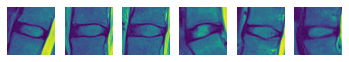

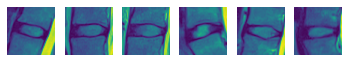

In [ ]:
"""
Sanity test
"""

plt.figure()
for i, fp in enumerate(Disc_paths['grade1'][49:]):
  plt.subplot(1, 6, i+1)
  plt.imshow(plt.imread(fp)); plt.axis('off')
plt.show()

plt.figure()
for item, label in test_dataset.take(1):
  for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(item[i, ..., 0]); plt.axis('off')
plt.show()


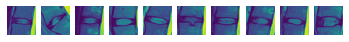

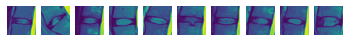

In [ ]:
"""
Sanity test
"""

plt.figure()
for i, fp in enumerate(filepath_test[20:30]):
  plt.subplot(1, 10, i+1)
  plt.imshow(plt.imread(fp)); plt.axis('off')
plt.show()

plt.figure()
for item, label in test_dataset.take(1):
  for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(item[i+20, ..., 0]); plt.axis('off')
plt.show()

# model

In [ ]:
"""
Base model definition for hyper parameter tuning
"""

def get_model_3D_CTscans(hp):
  """Build a 2D convolutional neural network model."""

  image_size=(64,64)
  input_shape = image_size + (1,)
  model = keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal"),
                            layers.experimental.preprocessing.RandomRotation(.1)])
  model.add(keras.Input(shape=input_shape))
  model.add(layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='valid', activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
  model.add(layers.MaxPool2D(pool_size=2))
  model.add(layers.BatchNormalization())

  for i in range(hp.Int("num_layers", 1, 6)):
    model.add(
          layers.Conv2D(
              # Tune number of filters separately.
              filters=hp.Int(f"filters_{i}",  min_value=32, max_value=512, step=32),
              kernel_size=3,
              activation=hp.Choice("activation", ["relu", "tanh", "elu"]),
              # activation = hp.Choice(name = 'activation', values = ['relu', 'tanh', 'elu'], ordered = False),
              kernel_regularizer=regularizers.l1_l2(l1=hp.Float("l1", min_value=1e-5, max_value=1e-4, sampling="log"),
                                                    l2=hp.Float("l2", min_value=1e-5, max_value=1e-4, sampling="log")),
              padding='same'        
          ))
    model.add(layers.MaxPool2D(pool_size=2, padding='same'))
    model.add(layers.BatchNormalization())

  model.add(layers.GlobalAveragePooling2D())

  for i in range(hp.Int("num_layers", 1, 6)):
    model.add(
          layers.Dense(
              # Tune number of units separately.
              units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
              activation=hp.Choice("activation", ["relu", "tanh"]),
              kernel_regularizer=regularizers.l2(.001)
          )
     )
  
  if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
  
  model.add(layers.Dense(5, activation="softmax"))
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      loss="binary_crossentropy",
      metrics=["accuracy"],
  )

  return model



model = get_model_3D_CTscans(kt.HyperParameters())
model.build(input_shape=(None, 64, 64, 1))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 64, 64, 1)         0         
                                                                 
 random_rotation (RandomRota  (None, 64, 64, 1)        0         
 tion)                                                           
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 64)       2

In [ ]:
"""
Tuner
"""

tuner = kt.BayesianOptimization(
    hypermodel=get_model_3D_CTscans,
    objective="val_accuracy",
    max_trials=100,
    alpha=0.0001,
    beta=2.6,
    directory="3D_CTscan",
    project_name="DiscGrading_hp",
)

tuner.search_space_summary()


Search space summary
Default search space size: 8
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': None}
filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu'], 'ordered': False}
l1 (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.0001, 'step': None, 'sampling': 'log'}
l2 (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.0001, 'step': None, 'sampling': 'log'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
"""
Search for best hyper parameters
"""
tuner.search(x_train, y_train, epochs=100, validation_data=(x_val, y_val))
# tuner.search(train_dataset,
#              steps_per_epoch=batch_size,
#              validation_data=validation_dataset,
#              validation_steps=8,
#              epochs=100,
#              initial_epoch=0)

Trial 100 Complete [00h 02m 02s]
val_accuracy: 0.7931034564971924

Best val_accuracy So Far: 0.8122605085372925
Total elapsed time: 04h 32m 00s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# !rm -rf 3D_CTscan

In [ ]:
tuner.results_summary()

Results summary
Results in 3D_CTscan/DiscGrading_hp
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 6
filters_0: 512
activation: elu
l1: 1e-05
l2: 1e-05
units_0: 512
dropout: False
lr: 0.0001
filters_1: 512
units_1: 512
filters_2: 32
filters_3: 32
filters_4: 32
filters_5: 32
units_2: 512
units_3: 32
units_4: 480
units_5: 512
Score: 0.8122605085372925
Trial summary
Hyperparameters:
num_layers: 6
filters_0: 320
activation: relu
l1: 7.374636443070327e-05
l2: 7.611088068533377e-05
units_0: 32
dropout: False
lr: 0.002051475801964024
filters_1: 32
units_1: 512
filters_2: 32
filters_3: 32
filters_4: 32
filters_5: 32
units_2: 32
units_3: 32
units_4: 32
units_5: 32
Score: 0.8045976758003235
Trial summary
Hyperparameters:
num_layers: 6
filters_0: 512
activation: elu
l1: 1e-05
l2: 1e-05
units_0: 512
dropout: False
lr: 0.0001
filters_1: 512
units_1: 512
filters_2: 512
filters_3: 32
filters_4: 32
filters_5: 512
units_2: 32
units_3: 3

In [ ]:
"""
loading the model with the best hyper parameters and training it 
"""

# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters()
# Build the model with the best hp.
model = get_model_3D_CTscans(best_hps[0])
print(model.get_config())
model.build(input_shape=(None, 64, 64, 1))
model.summary()
# Fit with the entire dataset.
x_all = np.concatenate((x_train, x_val))
y_all = np.concatenate((y_train, y_val))
# model.fit(x=x_all, y=y_all, epochs=100)
checkpoint_path = Path(os.path.join(path,'2d_image_classification.h5'))
checkpoint_cb=keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,monitor='val_accuracy',save_best_only=True)

epochs=100
history=model.fit(
    x=x_all, y=y_all,
    validation_data=(x_test,y_test),
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb],
)



In [ ]:
"""
If you have not searched for best tuned model in this session, run this section
to load the most recent tuned model and train it 
"""

checkpoint_path = Path(os.path.join(path,'2d_image_classification.h5'))
best_model = keras.models.load_model(checkpoint_path)
best_model_clone = tf.keras.models.clone_model(best_model)
best_model_clone.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

checkpoint_path_after = Path(os.path.join(path,'2d_image_classification1.h5'))
checkpoint_cb12=keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_after,monitor='val_accuracy',save_best_only=True)

# Fit with the entire dataset.
x_all = np.concatenate((x_train, x_val))
y_all = np.concatenate((y_train, y_val))
epochs=100
history=best_model_clone.fit(
    x=x_all, y=y_all,
    validation_data=(x_test,y_test),
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb12],
)

In [ ]:
best_model_clone.summary()

In [ ]:
"""
If you just want to check with your best trained model run this
"""
directory = "3D_CTscan" # Save the entire model as a SavedModel.
# parent_dir = os.getcwd() # Parent Directory path
parent_dir = '/content/drive/MyDrive/PhD/Barocas/grading/MyModels/DiscGrade'
path = os.path.join(parent_dir, directory) # Path

checkpoint_path_after = Path(os.path.join(path,'2d_image_classification1.h5'))
best_model_clone = keras.models.load_model(checkpoint_path_after)
best_model_clone.evaluate(x=x_test, y=y_test)


9/9 [==============================] - 9s 40ms/step - loss: 0.4114 - accuracy: 0.7828


[0.41144242882728577, 0.7827715277671814]

In [ ]:
# save the results from the classification model
classification_predictions = np.argmax(best_model_clone.predict(x_test), axis=1)+1  # +1 because indexing starts at zero 

y_test_cat = np.where(y_test!=0)[1]+1

test_results_df = pd.DataFrame(data={'class_pred':classification_predictions, 'label':y_test_cat})
test_results_df.to_csv(os.path.join(path,'classification_test_results.csv'))

In [ ]:
y_test_cat[:10]

array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


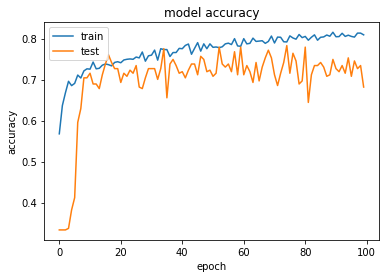

In [ ]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(os.path.join(path,'accuracy.png'))
plt.show()


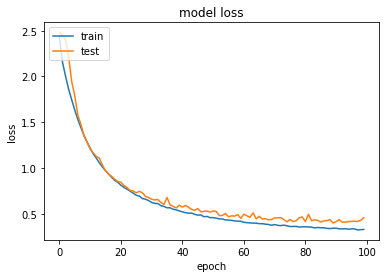

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
"""
Error analysis to see which images were mislabeled and what was the predicted and ground truth labels.
Save the images in error analysis folder.
Save a dictionary (file_path_error) containig the indices of mislabeld test images associated to their groups
"""

directory = "error_analysis" # Save the entire model as a SavedModel.
parent_dir = path
fig_path = os.path.join(parent_dir, directory) # Path
os.makedirs(fig_path,exist_ok=True) # Create the directory


it = iter(test_dataset)
file_path_error = {'1':[], '2':[], '3':[], '4':[]}


ct = 0
for test_item, test_label in it:
  ct+=1
  predicted_label = best_model.predict(test_item)
  diff = (np.round(predicted_label, 0) - test_label).numpy()
  
  for i in range(diff.shape[0]):
    if np.any(diff[i]!=0):
      print(diff[i])
      if np.sum(diff[i])!=0:  # [0, -1, 0, 0, 0] not sure at all (nothing >= 0.5)
        file_name = '4_not_sure'
        file_path_error['4'].append((ct-1)*32+i) 
      else:
        ix_n1 = np.squeeze(np.where(diff[i]==-1))
        ix_p1 = np.squeeze(np.where(diff[i]==+1))
        if np.abs(ix_n1-ix_p1)>1: 
          file_name = '3_very_wrong'  # [0, -1, 0, 1, 0] more than 1 grade wrong
          file_path_error['3'].append((ct-1)*32+i) 
        else:
          if np.any(predicted_label[i]>=0.75): # if confidence in one specific grade is above 75%
            file_name = '1_one_class_wrong_high_confidence'  # [0, -1, +1, 0, 0] exactly 1 grade wrong
            file_path_error['1'].append((ct-1)*32+i) 
          else:
            file_name = '2_one_class_wrong_low_confidence_almost_right'
            file_path_error['2'].append((ct-1)*32+i) 
    
      plt.figure()
      plt.imshow(test_item[i, ..., 0], cmap=plt.cm.gray); plt.axis('off')
      plt.title(f'pred, {np.round(predicted_label[i], 1)} lab, {test_label[i]}')
      plt.savefig(fname = Path(fig_path).joinpath(f'{file_name}_{ct}_{i}.png')) # ct: batch number, i: item number in the batch
      plt.close()
      # print(np.round(predicted_label[i], 1))
      # plt.imshow(test_item[i, ..., 0], cmap=plt.cm.gray); plt.axis('off')
      # plt.show()

print(file_path_error)

[-1  1  0  0  0]
[-1  0  1  0  0]
[-1  0  1  0  0]
[-1  0  0  0  0]
[-1  1  0  0  0]
[-1  0  0  0  0]
[ 0 -1  1  0  0]
[ 0 -1  1  0  0]
[ 0 -1  1  0  0]
[ 0 -1  1  0  0]
[ 0 -1  1  0  0]
[ 0 -1  0  0  0]
[ 0 -1  1  0  0]
[ 0 -1  1  0  0]
[ 0 -1  1  0  0]
[ 0 -1  1  0  0]
[ 0 -1  1  0  0]
[ 0 -1  1  0  0]
[ 0 -1  1  0  0]
[ 0 -1  1  0  0]
[ 0 -1  1  0  0]
[ 0 -1  1  0  0]
[ 0  1 -1  0  0]
[ 0  1 -1  0  0]
[ 0  1 -1  0  0]
[ 0  0 -1  1  0]
[ 0  1 -1  0  0]
[ 0  0 -1  1  0]
[ 0  1 -1  0  0]
[ 0  0 -1  1  0]
[ 0  1 -1  0  0]
[ 0  1 -1  0  0]
[ 0  0 -1  0  0]
[ 0  0 -1  1  0]
[ 0  1 -1  0  0]
[ 0  0 -1  1  0]
[ 0  0 -1  1  0]
[ 0  1 -1  0  0]
[ 0  0 -1  1  0]
[ 0  0 -1  1  0]
[ 0  1 -1  0  0]
[ 0  0 -1  1  0]
[ 0  0 -1  1  0]
[ 0  1 -1  0  0]
[ 0  0 -1  1  0]
[ 0  0 -1  1  0]
[ 0  0 -1  1  0]
[ 0  0  1 -1  0]
[ 0  0  1 -1  0]
[ 0  0  1 -1  0]
[ 0  0  1 -1  0]
[ 0  0  0 -1  1]
[ 0  0  1 -1  0]
[ 0  0  1 -1  0]
[ 0  0  1 -1  0]
[ 0  0  1 -1  0]
[ 0  0  0  1 -1]
[ 0  0  1  0 -1]
[ 0  0  0  1 -

In [ ]:
"""
find the paths to mislabeled images
"""

filepath_test = np.array(filepath_test)
path_to_err_type_1_and_2 =filepath_test[file_path_error['1']+file_path_error['2']]
path_to_err_type_3 =filepath_test[file_path_error['3']]
path_to_err_type_4 =filepath_test[file_path_error['4']]

textfile = open(os.path.join(path,"path_to_err_type_1_and_2.txt"), "w")
for element in path_to_err_type_1_and_2:
    textfile.write(element + "\n")
textfile.close()

textfile = open(os.path.join(path,"path_to_err_type_3.txt"), "w")
for element in path_to_err_type_3:
    textfile.write(element + "\n")
textfile.close()

textfile = open(os.path.join(path,"path_to_err_type_4.txt"), "w")
for element in path_to_err_type_4:
    textfile.write(element + "\n")
textfile.close()


In [ ]:
with open(os.path.join(path,"path_to_err_type_1_and_2.txt")) as f:
  err_type_1_and_2 = f.read().splitlines() 

name_err_type_1_and_2 = []
level_err_type_1_and_2 = []
for i, element in enumerate(err_type_1_and_2):
  info = element.split('/')[-1].split(' ')
  name_err_type_1_and_2.append(info[0])
  level_err_type_1_and_2.append(info[1].split('.')[0])
  
print(name_err_type_1_and_2)
print(level_err_type_1_and_2)

with open(os.path.join(path,"path_to_err_type_3.txt")) as f:
  err_type_3 = f.read().splitlines() 

name_err_type_3 = []
level_err_type_3 = []
for i, element in enumerate(err_type_3):
  info = element.split('/')[-1].split(' ')
  name_err_type_3.append(info[0])
  level_err_type_3.append(info[1].split('.')[0])
  
print(name_err_type_3)
print(level_err_type_3)

with open(os.path.join(path,"path_to_err_type_4.txt")) as f:
  err_type_4 = f.read().splitlines() 

name_err_type_4 = []
level_err_type_4 = []
for i, element in enumerate(err_type_4):
  info = element.split('/')[-1].split(' ')
  name_err_type_4.append(info[0])
  level_err_type_4.append(info[1].split('.')[0])
  
print(name_err_type_4)
print(level_err_type_4)

['T2_TSE_SAG__0167_008.ima', 'T2_TSE_SAG__0442_008.ima', 'T2_TSE_SAG__0432_008.ima', 'T2_TSE_SAG__0464_008.ima', 'T2_TSE_SAG__0075_008.ima', 'T2_TSE_SAG__0436_008.ima', 'T2_TSE_SAG__0278_008.ima', 'T2_TSE_SAG__0214_008.ima', 'T2_TSE_SAG__0298_008.ima', 'T2_TSE_SAG__0356_008.ima', 'T2_TSE_SAG__0171_008.ima', 'T2_TSE_SAG__0290_008.ima', 'T2_TSE_SAG__0290_008.ima', 'T2_TSE_SAG__0345_008.ima', 'T2_TSE_SAG__0550_008.ima', 'T2_TSE_SAG__0271_008.ima', 'T2_TSE_SAG__0539_008.ima', 'T2_TSE_SAG__0484_008.ima', 'T2_TSE_SAG__0270_008.ima', 'T2_TSE_SAG__0228_008.ima', 'T2_TSE_SAG__0081_008.ima', 'T2_TSE_SAG__0479_008.ima', 'T2_TSE_SAG__0027_015.ima', 'T2_TSE_SAG__0515_008.ima', 'T2_TSE_SAG__0174_008.ima', 'T2_TSE_SAG__0062_008.ima', 'T2_TSE_SAG__0234_008.ima', 'T2_TSE_SAG__0322_008.ima', 'T2_TSE_SAG__0381_008.ima', 'T2_TSE_SAG__0126_008.ima', 'T2_TSE_SAG__0550_008.ima', 'T2_TSE_SAG__0039_008.ima', 'T2_TSE_SAG__0062_008.ima', 'T2_TSE_SAG__0467_008.ima', 'T2_TSE_SAG__0218_008.ima', 'T2_TSE_SAG__0380_0

In [ ]:
"""
Compares the agreement of Ladd and Takahashi on the mislabeled images to find how many of mislabeled
images are also mislabeled by these to specialist
"""

path_to_scores_Ladd = '/content/drive/MyDrive/PhD/Barocas/grading/LumbarDiscJointScoring_Main/scores/Bryan Ladd'
Ladd_disc = pd.read_csv(os.path.join(path_to_scores_Ladd,'Scores(discs)_Ladd.csv'), header=None)

path_to_scores_Takahashi = '/content/drive/MyDrive/PhD/Barocas/grading/LumbarDiscJointScoring_Main/scores/Takashi Takahashi'
Takahashi_disc = pd.read_csv(os.path.join(path_to_scores_Takahashi,'Scores(discs)_Takahashi.csv'), header=None)
counter_1_and_2 = 0

for i, element in enumerate(name_err_type_1_and_2):
  Ladd_scores = list(Ladd_disc[Ladd_disc[0]==element].iloc[0,1:-1])
  Takahashi_scores = list(Takahashi_disc[Takahashi_disc[0]==element].iloc[0,1:-1])
  if level_err_type_1_and_2[i]=='L1_L2':
    if (Ladd_scores[0] != Takahashi_scores[0]):
      counter_1_and_2 += 1
  elif level_err_type_1_and_2[i]=='L2_L3':
    if (Ladd_scores[1] != Takahashi_scores[1]):
      counter_1_and_2 += 1 
  elif level_err_type_1_and_2[i]=='L3_L4':
    if (Ladd_scores[2] != Takahashi_scores[2]):
      counter_1_and_2 += 1 
  elif level_err_type_1_and_2[i]=='L4_L5':
    if (Ladd_scores[3] != Takahashi_scores[3]):
      counter_1_and_2 += 1  
  else:
    if (Ladd_scores[4] != Takahashi_scores[4]):
      counter_1_and_2 += 1  

  # print(level_err_type_1_and_2[i])
  # print(Ladd_scores)
  # print(Takahashi_scores)
  # print()


counter_3 = 0
for i, element in enumerate(name_err_type_3):
  Ladd_scores = list(Ladd_disc[Ladd_disc[0]==element].iloc[0,1:-1])
  Takahashi_scores = list(Takahashi_disc[Takahashi_disc[0]==element].iloc[0,1:-1])
  if level_err_type_3[i]=='L1_L2':
    if (Ladd_scores[0] != Takahashi_scores[0]):
      counter_3 += 1
  elif level_err_type_3[i]=='L2_L3':
    if (Ladd_scores[1] != Takahashi_scores[1]):
      counter_3 += 1 
  elif level_err_type_3[i]=='L3_L4':
    if (Ladd_scores[2] != Takahashi_scores[2]):
      counter_3 += 1 
  elif level_err_type_3[i]=='L4_L5':
    if (Ladd_scores[3] != Takahashi_scores[3]):
      counter_3 += 1  
  else:
    if (Ladd_scores[4] != Takahashi_scores[4]):
      counter_3 += 1  

  # print(level_err_type_3[i])
  # print(Ladd_scores)
  # print(Takahashi_scores)
  # print()
  

counter_4 = 0
for i, element in enumerate(name_err_type_4):
  Ladd_scores = list(Ladd_disc[Ladd_disc[0]==element].iloc[0,1:-1])
  Takahashi_scores = list(Takahashi_disc[Takahashi_disc[0]==element].iloc[0,1:-1])
  if level_err_type_4[i]=='L1_L2':
    if (Ladd_scores[0] != Takahashi_scores[0]):
      counter_4 += 1
  elif level_err_type_4[i]=='L2_L3':
    if (Ladd_scores[1] != Takahashi_scores[1]):
      counter_4 += 1 
  elif level_err_type_4[i]=='L3_L4':
    if (Ladd_scores[2] != Takahashi_scores[2]):
      counter_4 += 1 
  elif level_err_type_4[i]=='L4_L5':
    if (Ladd_scores[3] != Takahashi_scores[3]):
      counter_4 += 1  
  else:
    if (Ladd_scores[4] != Takahashi_scores[4]):
      counter_4 += 1  

  # print(level_err_type_4[i])
  # print(Ladd_scores)
  # print(Takahashi_scores)
  # print()


print(counter_1_and_2)
print(counter_3)
print(counter_4)



34
3
3
